# Imports

In [44]:
import pennylane as qml
import matplotlib.pyplot as plt
import numpy as np
from tqdm import trange

# Functions

In [17]:
def plot_bloch_sphere():
    # plot the path on Bloch sphere!
    u = np.linspace(0, np.pi, 31)
    v = np.linspace(0, 2 * np.pi, 30)

    bloch_x = np.outer(np.sin(u), np.sin(v))
    bloch_y = np.outer(np.sin(u), np.cos(v))
    bloch_z = np.outer(np.cos(u), np.ones_like(v))

    fig = plt.figure()
    ax = plt.axes(projection='3d')

    ax.plot_wireframe(bloch_x, bloch_y, bloch_z, color='k',alpha=0.1)
    ax.plot(np.cos(v), np.sin(v), 0, color='k', alpha=0.2)
    ax.set_box_aspect([1,1,1])
    ax.azim += 90
    plt.axis('off')

    # Make a 3D quiver plot
    x, y, z = np.zeros((3,3))
    u, v, w = np.array([[1.3,0,0],[0,1.3,0],[0,0,1.3]])

    ax.quiver(x,y,z,u,v,w,arrow_length_ratio=0.1, color='k')

    plt.tight_layout(pad=0.1)

    return ax

<Axes3D: >

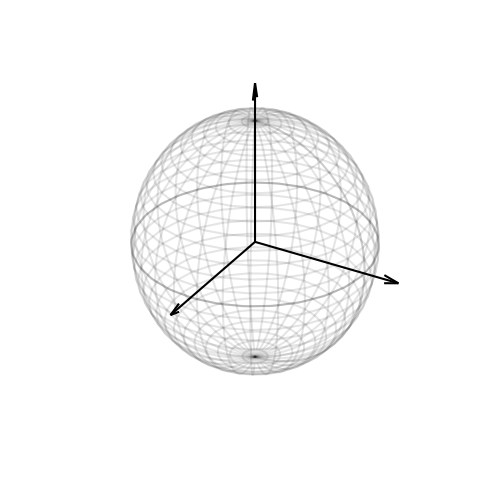

In [18]:
plot_bloch_sphere()

# Circuit

In [19]:
dev = qml.device("default.qubit", wires=1)

In [20]:
@qml.qnode(dev)
def Rotation_circuit(initial, thetas):

    # creates the initial state
    qml.RY(initial[0], wires=0)
    qml.RZ(initial[1], wires=0)

    # general rotation
    qml.RZ(thetas[0], wires=0)
    qml.RY(thetas[1], wires=0)
    qml.RZ(thetas[2], wires=0)

    return qml.expval(qml.PauliX(0)), qml.expval(qml.PauliY(0)), qml.expval(qml.PauliZ(0))

In [33]:
def loss(target, pred):
    return np.sqrt(np.sum((target - pred)**2))

In [35]:
def compute_gradients(initial, thetas, delta=0.01):
    gradients = np.zeros_like(thetas)
    for i in range(len(thetas)):
        thetas[i] += delta
        forward = Rotation_circuit(initial, thetas)
        thetas[i] -= 2*delta
        backward = Rotation_circuit(initial, thetas)

        loss_forward = loss(target_vector, forward)
        loss_backward = loss(target_vector, backward)

        gradients[i] = (loss_forward - loss_backward) / (2 * delta)
        thetas[i] += delta
    return gradients

In [36]:
def decent_step(initial, thetas, y_true, learning_rate=0.1):
    gradients = compute_gradients(initial, thetas)
    y_pred = Rotation_circuit(initial, thetas)
    thetas -= learning_rate * gradients
    return thetas, loss(y_true, y_pred)

In [38]:
def gradient_descent(initial, target, thetas, learning_rate=0.1, epochs=100):
    losses = []
    thetas_history = []
    for i in trange(epochs):
        thetas, loss_value = decent_step(initial, thetas, target)
        losses.append(loss_value)
        thetas_history.append(thetas)
    return thetas, losses, thetas_history

# Training Example

In [54]:
# Create initial state
initial = np.random.normal(size=2)
initial /= np.linalg.norm(initial)

# Compute the initial vector
initial_vector = Rotation_circuit(initial, np.zeros(3))

print("Initial vector:", initial_vector)

Initial vector: (np.float64(0.7446673412331175), np.float64(0.2924370567925333), np.float64(0.5999592642132634))


In [55]:
# Create target state
target_vector = np.random.normal(size=3)
target_vector /= np.linalg.norm(target_vector)
print("Target vector:", target_vector)

Target vector: [ 0.70506966 -0.60377062 -0.3719379 ]


In [56]:
# Initial thetas set at 0
thetas = np.zeros(3)

In [57]:
# Run the optimization
res, losses, hist = gradient_descent(initial, target_vector, thetas, epochs=50)

100%|██████████| 50/50 [00:00<00:00, 68.25it/s]


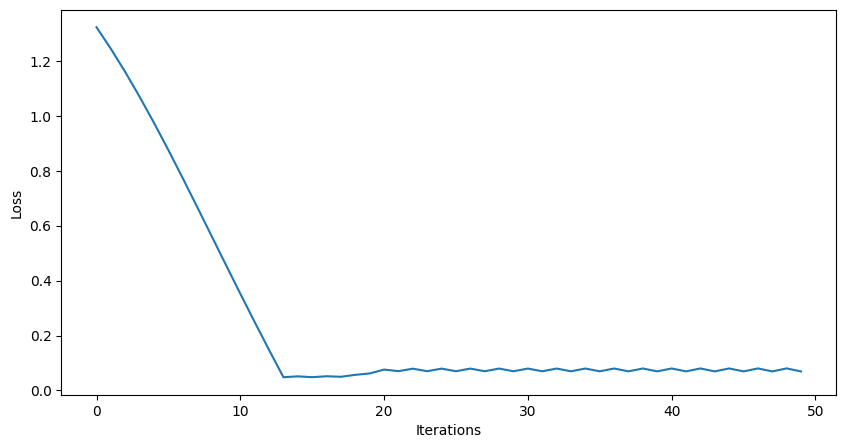

In [58]:
# Plot the loss
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()